In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from simulation import FridgeDRSim

In [6]:
sim = FridgeDRSim(rto='CAISO')

Error: 2024-01-01 - Error: 2024-01-01 has 24 hours of data, expected 25
Error: 2024-03-10 - Error: 2024-03-10 has 24 hours of data, expected 25
Error: 2024-11-03 - Error: 2024-11-03 has 26 hours of data, expected 25


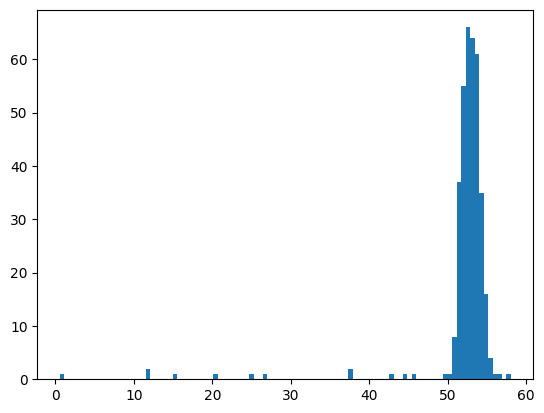

In [7]:
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')

valid_dates = []
peak_shaving = []
for dt in dates:
    date = dt.strftime('%Y-%m-%d')
    try:
        results = sim.run(date)
        peak_shaving.append(results['stats']['mw_reduction'])
        if results['stats']['mw_reduction'] < 0:
            print(date)
        valid_dates.append(date)
    except Exception as e:
        print(f"Error: {date} - {e}")
        pass

peak_shaving = np.array(peak_shaving)
plt.hist(peak_shaving, bins=100);

In [8]:
valid_dates[np.argmax(peak_shaving)]

'2024-04-06'

In [12]:
d = '2024-04-06'
r = sim.run(d)
r['stats']

{'original_peak': np.float64(23139.69),
 'new_peak': np.float64(23081.621024999997),
 'mw_reduction': np.float64(58.068975000001956)}

In [13]:
def plot_grid_impact(sim_results):
    df_grid_min = sim_results['grid_data']
    original_grid_profile = sim_results['original_grid_profile']
    new_grid_profile = sim_results['new_grid_profile']
    sim_len = sim_results['sim_length']

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    for ax in axs:
        # Plot Original vs New
        ax.plot(df_grid_min.index[:sim_len], original_grid_profile, 'k--', alpha=0.5, label='Original ISO-NE Load')
        ax.plot(df_grid_min.index[:sim_len], new_grid_profile, 'g-', linewidth=2, label=f'With DR')

        # Fill the difference to highlight the "Peak Shaving"
        ax.fill_between(
            df_grid_min.index[:sim_len], 
            original_grid_profile, 
            new_grid_profile, 
            where=(original_grid_profile > new_grid_profile),
            color='green', alpha=0.3, label='Peak Shaved'
        )

        # Fill the "Rebound" (Charging)
        ax.fill_between(
            df_grid_min.index[:sim_len], 
            original_grid_profile, 
            new_grid_profile, 
            where=(original_grid_profile < new_grid_profile),
            color='red', alpha=0.3, label='Recharge Impact'
        )

        ax.set_ylabel("Grid Load (MW)")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    ymax = np.max(original_grid_profile) + 100
    try:
        recharge_start = np.where(original_grid_profile < new_grid_profile)[0][0]
        ymin = original_grid_profile[recharge_start] - 200
    except IndexError:
        ymin = original_grid_profile[0] - 200
    xmin = pd.Timestamp(f'{sim_results["date"]} {int(sim_results["dr_start_hour"])}:00:00')
    xmax = pd.Timestamp(f'{sim_results["date"]} {int(sim_results["dr_end_hour"])}:00:00')
    axs[1].set_ylim([ymin, ymax])
    axs[1].set_xlim([xmin - pd.Timedelta(minutes=30), xmax + pd.Timedelta(hours=4)])
    plt.show()

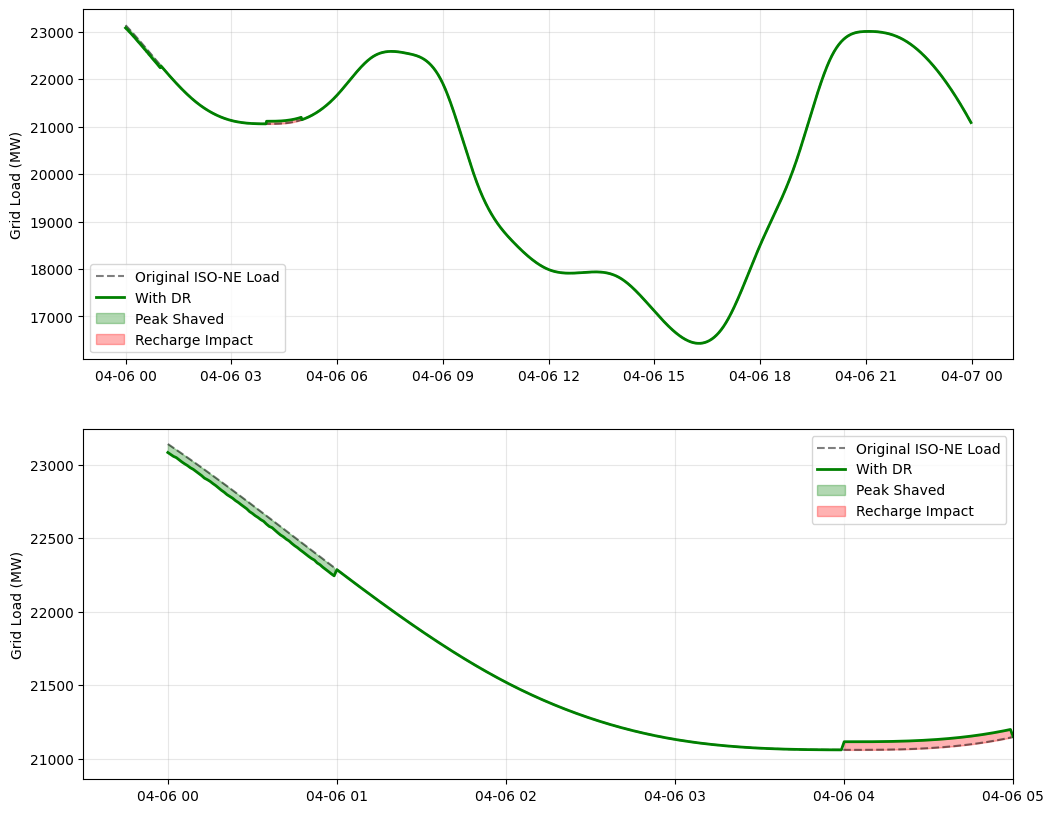

In [14]:
plot_grid_impact(r)